In [1]:
import sys
import copy
sys.path.insert(0, "../../")
from classes.calculators.lennardjones import LennardJones
from classes.atom_classes.atom import Atom
from classes.atom_classes.atom_collection import Atom_Collection
from classes.atom_classes.atom_collection_plotter import Atom_Collection_Plotter, Animator
from classes.atom_classes.atom_file_handler import Atom_File_handler
from classes.optimizers.md_simulator1 import MDT_simulator
from classes.optimizers.random_struct_search import Line_searcher1
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
plt.rc('animation', html='jshtml')

In [2]:
class MD_animator(Animator):
    def __init__(self, 
                 e_line,
                 default_cols=("C0", "C1"), markersize=50, scale_with_mass=False, alpha=1) -> None:
        super().__init__(default_cols, markersize, scale_with_mass, alpha)
        self.e_line = e_line

    def animate(self, i, atom_col, position, energies):
        cm_pos = np.mean(position,axis=0)
        #print("hov")
        atom_col.set_atom_positions(position-cm_pos)
        plot_elems = self(atom_col)
        xs = np.linspace(0, i, i)
        self.e_line.set_data(xs, energies[:i])
        return plot_elems["atoms"] + [self.e_line]

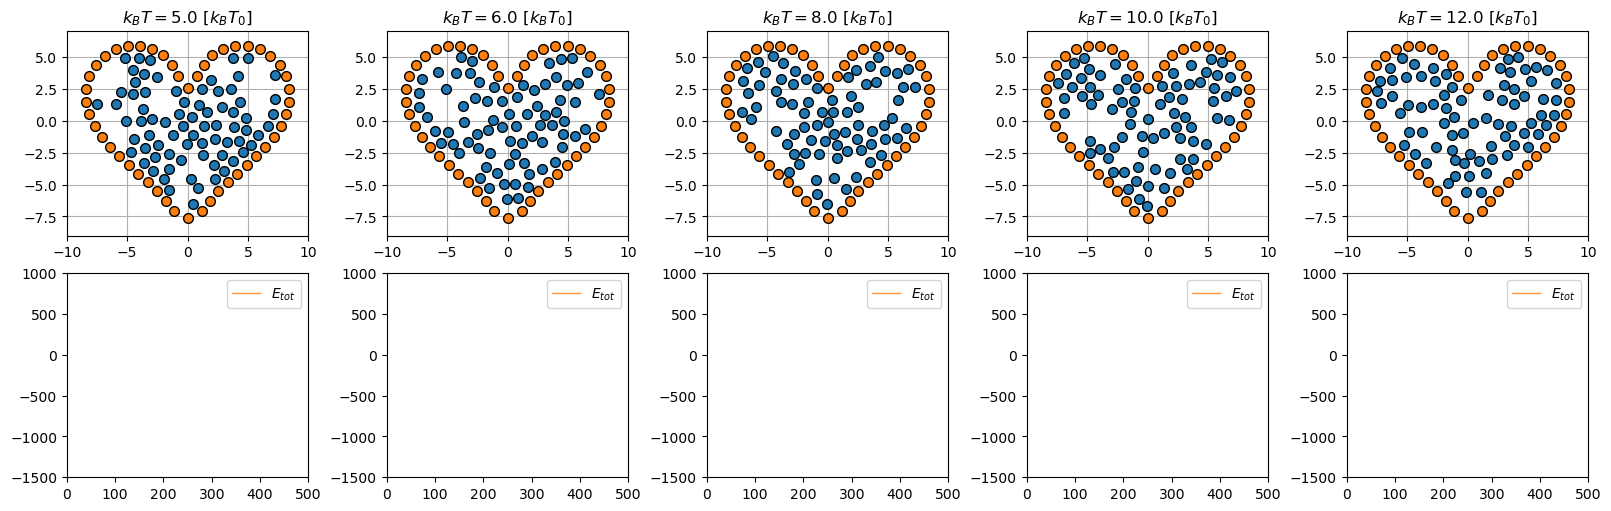

In [7]:
fig, axs = plt.subplots(2,5, figsize=(16,5), layout="constrained")

atom_writer = Atom_File_handler()
temps = [5.0, 6.0, 8.0, 10.0, 12.0]

logged_atom_cols = [atom_writer.load_atom_collections(filename=f"saved_atom_cols/T{temp}sim") for temp in temps]

temp_sims = temps

plot_cols = [copy.deepcopy(logged_atom_cols[i][0]) for i in range(len(temps))]

md_animators = []
for ax in axs[1]:
    ax.set_xlim([0, 500])
    ax.set_ylim([-1500, 1000])
    e_line = ax.plot([],[], "-",c="C1",label=r"$E_{tot}$", lw=1, alpha=0.8)[0]
    ax.legend()
    md_animators.append(MD_animator(e_line=e_line, markersize=7))

for ax, temp, md_animator, plot_col in zip(axs[0], temp_sims, md_animators, plot_cols):
    plot_col.reset_plot_axes()
    md_animator(atom_col=plot_col, ax=ax)
    ax.set_title(r"$k_{B}T=$"+f"{round(temp,3)}"+r" $\left[k_{B}T_0\right]$")
    ax.grid()
    ax.set_xlim([-10.0, 10.0])
    ax.set_ylim([-9.0, 7.0])

In [8]:
def update(i, md_animators, plot_cols, logged_atom_cols, sim_nums):
    tot_plot_elems = []
    for md_animator, plot_col, sim_num in zip(md_animators, plot_cols, sim_nums):
        md_atom_cols = logged_atom_cols[sim_num][:i]
        pot_es = np.array([md_atom_col.get_potential_energy() for md_atom_col in md_atom_cols])
        kin_es = np.array([md_atom_col.get_kinetic_energy() for md_atom_col in md_atom_cols])
        tot_es = pot_es + kin_es
        if i > 0:
            position = md_atom_cols[-1].positions
            tot_plot_elems+= md_animator.animate(i, plot_col, position, tot_es)
    return tot_plot_elems

In [9]:
anim = animation.FuncAnimation(fig,
                               update,
                               frames=np.arange(0, 499, 10),
                               fargs=(md_animators, plot_cols, logged_atom_cols, range(len(temps))),
                               interval=75,
                               blit=True)
anim

In [ ]:
writer = animation.PillowWriter(fps=15,
                                 metadata=dict(artist='Me'),
                                 bitrate=1800)
anim.save("5.0-12.0.gif", writer=writer)